# 06: Face pose dlib/MTCNN

In [1]:
import os
import os.path as osp
from os.path import join
from glob import glob
import random

import cv2 as cv
import numpy as np
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import math
import dlib
from mtcnn.mtcnn import MTCNN

%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import im_utils
from app.models.bbox import BBox

In [2]:
def detect_faces_dlib(im,pyramids=0):
  rects = detector_dlib(im, pyramids)
  faces = [ (r.left(),r.top(),r.right(),r.bottom()) for r in rects] #x1,y1,x2,y2
  return faces

In [3]:
# init dlib
dlib_predictor_path = osp.join(cfg.DIR_MODELS_DLIB_68PT)
predictor = dlib.shape_predictor(dlib_predictor_path)
detector_dlib = dlib.get_frontal_face_detector()

In [4]:
regions = {
    "outside_mouth": {
        "points": list(range(49, 60+1)),
        "closed": True
        },
    "inside_mouth": {
        "points": list(range(61, 68)),
        "closed": True
        },
    "brow_left": {
        "points": list(range(18, 22+1)),
        "closed": False
        },
    "brow_right": {
        "points": list(range(23, 27+1)),
        "closed": False
        },
    "eye_right": {
        "points": list(range(37, 42+1)),
        "closed": True
        },
    "eye_left": {
        "points": list(range(43, 48+1)),
        "closed": True
        },
    "nose_bottom": {
        "points": list(range(31,36+1)),
        "closed": True
        },
    "nose_bridge": {
        "points": list(range(28,31+1)),
        "closed": False
        },
    "jaw": {
        "points": list(range(1, 17+1)),
        "closed": False
    }
}

In [5]:
def compute_pose(img, landmarks):
  # computes pose using 6 / 68 points from dlib face landmarks
  # based on learnopencv.com and 
  # https://github.com/jerryhouuu/Face-Yaw-Roll-Pitch-from-Pose-Estimation-using-OpenCV/
  # NB: not as accurate as MTCNN, see @jerryhouuu for ideas
  
  pose_points_idx = (30, 8, 36, 45, 48, 54)
  axis = np.float32([[500,0,0], [0,500,0], [0,0,500]])
  
  # 3D model points.
  model_points = np.array([
      (0.0, 0.0, 0.0),             # Nose tip
      (0.0, -330.0, -65.0),        # Chin
      (-225.0, 170.0, -135.0),     # Left eye left corner
      (225.0, 170.0, -135.0),      # Right eye right corne
      (-150.0, -150.0, -125.0),    # Left Mouth corner
      (150.0, -150.0, -125.0)      # Right mouth corner
  ])
  
  # Assuming no lens distortion
  dist_coeffs = np.zeros((4,1))
  rot_vec = None
  size = im.shape[:2]

  # find 6 pose points
  pose_points = []
  for j, idx in enumerate(pose_points_idx):
    pt = landmarks[idx]
    pose_points.append((pt[0], pt[1]))
  pose_points = np.array(pose_points, dtype='double')  # convert to double
  
  # create camera matrix
  size = img.shape
  focal_length = size[1]
  center = (size[1]/2, size[0]/2)
  cam_mat = np.array(
      [[focal_length, 0, center[0]],
      [0, focal_length, center[1]],
      [0, 1, 1]], dtype = "double"
  )
  
  # solve PnP for rotation and translation
  (success, rot_vec, tran_vec) = cv.solvePnP(model_points, pose_points, 
                                             cam_mat, dist_coeffs, 
                                             flags=cv.SOLVEPNP_ITERATIVE)  
  # project points
  pts_im, jac = cv.projectPoints(axis, rot_vec, tran_vec, cam_mat, dist_coeffs)
  pts_model, jac2 = cv.projectPoints(model_points, rot_vec, tran_vec, cam_mat, dist_coeffs)
  rvec_matrix = cv.Rodrigues(rot_vec)[0]
  
  # convert to degrees
  proj_matrix = np.hstack((rvec_matrix, tran_vec))
  eulerAngles = cv.decomposeProjectionMatrix(proj_matrix)[6] 
  pitch, yaw, roll = [math.radians(x) for x in eulerAngles]
  pitch = math.degrees(math.asin(math.sin(pitch)))
  roll = -math.degrees(math.asin(math.sin(roll)))
  yaw = math.degrees(math.asin(math.sin(yaw)))
  degrees = {'pitch': pitch, 'roll': roll, 'yaw': yaw}
  
  # add nose point
  pt_nose = tuple(landmarks[pose_points_idx[0]])
  
  return pts_im, pts_model, degrees, pt_nose


def draw_pose(im, pts_im, pts_model, pt_nose):
  cv.line(im, pt_nose, tuple(pts_im[1].ravel()), (0,255,0), 3) #GREEN
  cv.line(im, pt_nose, tuple(pts_im[0].ravel()), (255,0,), 3) #BLUE
  cv.line(im, pt_nose, tuple(pts_im[2].ravel()), (0,0,255), 3) #RED
  return im


def draw_degrees(im, degrees, color=(0,255,0)):
  for i, item in enumerate(degrees.items()):
    k, v = item
    t = '{}: {:.2f}'.format(k, v)
    origin = (10, 30 + (25 * i))
    cv.putText(im, t, origin, cv.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=2, lineType=2)

In [6]:
# get image files
dir_im = '/data_store/datasets/people/lfw/images/'
fp_ims = glob(join(dir_im, '**/*.jpg'),recursive=True)

In [7]:
fp_im = join(dir_im, 'AJ_Lamas/AJ_Lamas_0001.jpg')
fp_im = '/data_store_ssd/apps/megapixels/datasets/vgg_face2/raw/train/n004034/0194_01.jpg'

/data_store_ssd/apps/megapixels/datasets/vgg_face2/raw/train/n004034/0194_01.jpg


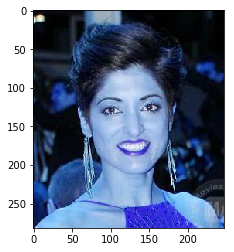

In [8]:
#fp_im = np.random.choice(fp_ims)
im = cv.imread(fp_im)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)
print(fp_im)

In [12]:
# Draw high-confidence faces
faces_dlib = detect_faces_dlib(im,pyramids=0)
face = faces_dlib[0] #biggest face
# Convert back to dlib.rectangle for predictor
roi_dlib = dlib.rectangle(face[0],face[1],face[2],face[3])
landmarks = [[p.x, p.y] for p in predictor(im_gray, roi_dlib).parts()]
print("Found {} face(s)".format(len(faces_dlib)))

Found 1 face(s)


In [13]:
pts_im, pts_model, degrees, pt_nose = compute_pose(im, landmarks)
print('pitch: {pitch}, roll: {roll}, yaw: {yaw}'.format(**degrees))

pitch: -0.43544687807480204, roll: 3.6990710673785228, yaw: -5.206583259373987


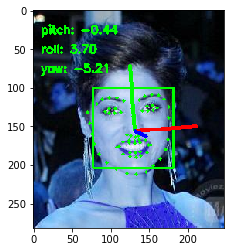

In [14]:
dst = im.copy()

for face in faces_dlib:
    x1,y1,x2,y2 = face
    cv.rectangle(dst,(x1,y1),(x2,y2),(0,255,0), 2)

for lm in landmarks:
    cv.circle(dst,(lm[0],lm[1]), 2, (0,255,0), -1)
    
draw_pose(dst, pts_im, pts_model, pt_nose)
draw_degrees(dst, degrees)

plt.imshow(dst)

In [15]:
import pandas as pd

In [20]:
files = ['rois_cvdnn_400.csv', 'rois_dlib_cnn_400_p1.csv', 'rois_dlib_hog_400_p1.csv', 'rois_mtcnn_400.csv']
dir_metadata = '/data_store/datasets/people/dating_site_jmoll/metadata/'

In [24]:
for fname in files:
  fp_rois = join(dir_metadata, fname)
  df_rois = pd.read_csv(fp_rois)
  print(f'file: {fname}\tfaces: {len(df_rois)}')

file: rois_cvdnn_400.csv	faces: 10169
file: rois_dlib_cnn_400_p1.csv	faces: 6256
file: rois_dlib_hog_400_p1.csv	faces: 3082
file: rois_mtcnn_400.csv	faces: 5189
